## Survival analysis - Smoking data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter

### Reading and cleaning - smoking data

We will perform the same cleaning procedure created by Vincent D. Warmerdam.

The exception is the creation of a `death` variable column.

Source: https://calmcode.io/smoking/cleaning.html

In [2]:
df = pd.read_csv('https://calmcode.io/datasets/smoking.csv')

In [3]:
df.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


In [4]:
def clean_dataframe(dataf):
    return (dataf
            .assign(alive=lambda d: (d['outcome'] == 'Alive').astype(np.int))
            .assign(smokes=lambda d: (d['smoker'] == 'Yes').astype(np.int))
            .assign(death=lambda d: (d['outcome'] != 'Alive').astype(np.int)))

clean_df = df.pipe(clean_dataframe)

In [5]:
clean_df.head()

,outcome,smoker,age,alive,smokes,death
0,Alive,Yes,23,1,1,0
1,Alive,Yes,18,1,1,0
2,Dead,Yes,71,0,1,1
3,Alive,No,67,1,0,0
4,Alive,No,64,1,0,0


### Framing the problem

By analyzing the data, the proportion of individuals that survive in the smokers versus non smokers groups are the following:

In [6]:
clean_df.groupby("smokes").agg({'alive': np.mean})

,alive
smokes,
0,0.685792
1,0.761168


76% of the smokers survive versus 68% of the non smokers. So, smoking is good for us? Strange, isn't it?

Probably might be a good idea to control our results by age. Let's check the age of both groups:

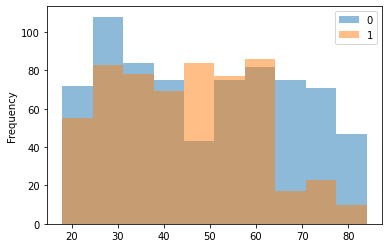

In [7]:
clean_df.groupby("smokes")['age'].plot(kind='hist', alpha=0.5, legend=True);

In [8]:
clean_df.groupby("smokes").agg({'alive': np.mean, 'age': [np.mean, np.std]})

alive        age           
            mean       mean        std
smokes                                
0       0.685792  48.699454  18.793713
1       0.761168  44.682131  15.275113

Hum... the two groups are not comparable when it comes to age. The non smokers group contains older individuals.

How can we estimate the effect of smoking in people survival through time?

### Smokers versus non smokers - a Survival Analysis view

The idea is to perform a [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis#:~:text=Survival%20analysis%20is%20a%20branch,and%20failure%20in%20mechanical%20systems.) study over the smoking dataset retrieving how a person's survival might be affected due to smoking.

Survival analysis makes possible for us to study how individuals survive along the time. Here our goal is to estimate the **survival function - S(t)**.

The survival function can be written as:

$S(t) = P(T>t)$, the probability an individual survives up to time t.

Among many possible estimators to estimate the survival curve, we will use the Kaplan-Meier estimator. Kaplan-Meier is a non-parametric estimator that can be written as:

$$\hat{S} = \prod_{i: t_i \leq t} (1-\frac{d_i}{n_i})$$, where

$d_i$: number of failures (in our case deaths) at time $t_i$

$n_i$: number of individuals in risk at time $t_i$

By using the number of individuals in risk along the time, each individual counts as a normalizer, even if at the end of the study time this individual has not experienced an event (in our case death). The individuals that have not experienced the event of interest (death) are called **censors**.

For each time window that a death ocurred, the $1-\frac{d_i}{n_i}$ term is calculated and the productory combines the current and all previous time windows to estimate the current survival: $S(t)$.

In [9]:
# Splitting data between smokers and non smokers
df_smoker = clean_df.query("smokes == 1")
df_non_smoker = clean_df.query("smokes == 0")

In [10]:
# Estimate survival for both groups

# Fitting a Kaplan-Meier estimator to smokers
kmf_smoker = KaplanMeierFitter()
kmf_smoker.fit(df_smoker['age'], df_smoker['death'])

# Fitting a Kaplan-Meier estimator to non smokers
kmf_non_smoker = KaplanMeierFitter()
kmf_non_smoker.fit(df_non_smoker['age'], df_non_smoker['death'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 732 total observations, 502 right-censored observations>

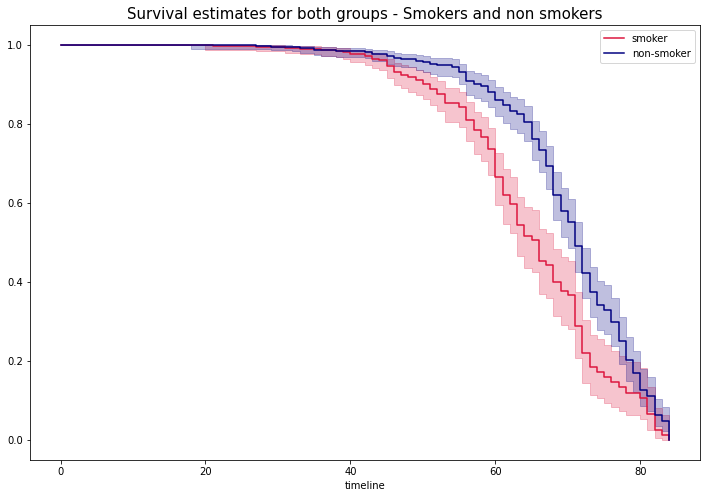

In [11]:
# Plotting survival estimates for both groups
plt.figure(figsize=(12,8))

ax = kmf_smoker.plot(color='crimson', label='smoker')

kmf_non_smoker.plot(ax=ax, color='navy', label='non-smoker')

plt.title("Survival estimates for both groups - Smokers and non smokers", size=15);

Ok, nice. As we thought, non smokers have a better survival curve with a higher proportion of individuals surviving longer than those who smoke.

Let's compute some statistics from both survival curves and compare them across groups:

* Median survival: 

At what time t we have: $ P(T>t) = 0.5 $


In [12]:
# Median survival - P(T>t) = 0.5 - for smokers
median_surv_smoker = kmf_smoker.median_survival_time_
median_surv_smoker

66.0

In [103]:
# Median survival - P(T>t) = 0.5 - for non smokers
median_surv_non_smoker = kmf_non_smoker.median_survival_time_
median_surv_non_smoker

71.0

In [104]:
# Relation between median survival times
median_surv_non_smoker/median_surv_smoker

1.0757575757575757

Ok, non smokers seem to have a median survival ~7.6% higher, or in years, 5 years, than those who smoke. That makes sense!!

What if we use the expected survival time? It is a weighted mean using all survival probabilities through time. So, it is the most probable survival horizon for each group (smokers and non smokers).

In [15]:
# Retrieving the survival estimates for both groups - smokers and non smokers
kmf_smoker_surv = kmf_smoker.survival_function_
kmf_non_smoker_surv = kmf_non_smoker.survival_function_

# Calculating the expected survival - area below survival curves
expected_time_smoker = np.trapz(kmf_smoker_surv, kmf_smoker.timeline, axis=0)[0]
expected_time_non_smoker = np.trapz(kmf_non_smoker_surv, kmf_non_smoker.timeline, axis=0)[0]

print(f"Expected survival for smokers: {expected_time_smoker: .0f}")
print(f"Expected survival for non smokers: {expected_time_non_smoker: .0f}")

Expected survival for smokers:  64
Expected survival for non smokers:  70


In [106]:
# Ratio between survival of both groups
expected_time_non_smoker/expected_time_smoker

1.0825082796125152

We estimate that non smokers live, in average, 8.25% longer than those who smoke. In years it represents 6 years.

### Survival difference between groups over time

What if we want to observe some cool statistics through time?

It is possible to compare the survival estimates for both groups and take some insights from the differences and odds between survival estimates and time estimates of both groups.

In [107]:
# Maximum survival for both groups - smokers and non smokers
SMOKER_MAX_SURVIVAL = kmf_smoker.timeline.max()
NON_SMOKER_MAX_SURVIVAL = kmf_non_smoker.timeline.max()

In [112]:
# Creating our time buckets
TIME_BUCKETS = np.arange(0, max(SMOKER_MAX_SURVIVAL, NON_SMOKER_MAX_SURVIVAL), 1)
TIME_BUCKETS

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83.])

In [135]:
# Survival at time buckets for both groups
survival_smoker = kmf_smoker.survival_function_at_times(TIME_BUCKETS)
survival_non_smoker = kmf_non_smoker.survival_function_at_times(TIME_BUCKETS)

# Survival difference and survival odds between groups
diff_survival = survival_non_smoker - survival_smoker
odds_survival = survival_non_smoker/survival_smoker

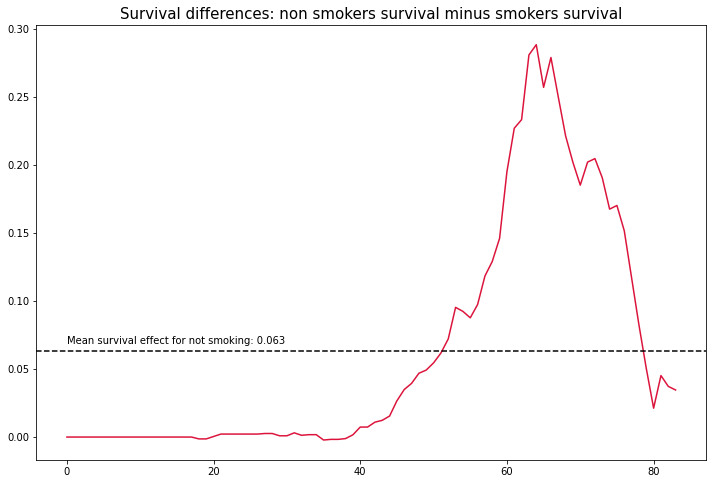

In [136]:
plt.figure(figsize=(12,8))
plt.plot(diff_survival, color='crimson')
plt.axhline(y=diff_survival.mean(),
            linestyle='--',
            color='black')
plt.text(x=0, 
         y=diff_survival.mean()+0.005,
         s=f"Mean survival effect for not smoking: {diff_survival.mean():.3f}")
plt.title("Survival differences: non smokers survival minus smokers survival", size=15);

From the graph above we can take two conclusions:

* Those who do not smoke have 28.8% more chances of surviving up to 65 years.
* In average, those who do not smoke have 6.3% more chances of surviving across all observed ages (up to 84 years).
* For the ones younger than 40 years, the study displays that smoking did not affect survival estimates between groups.
* From 40 years on, the survival of those in the non smoking group is significantly higher than those in the smoking group. Is this a carried effect from smoking over a long period? `Smoking history` (years smoking) would be a great variable to have to account for its effect in the estimation.
* After 65 years, the survival of both groups starts to converge.

If we take a look on the survival odds (survival of non smokers divided by the survival of smokers) we get an interesting view of how the risk of being part of the smokers group is high.

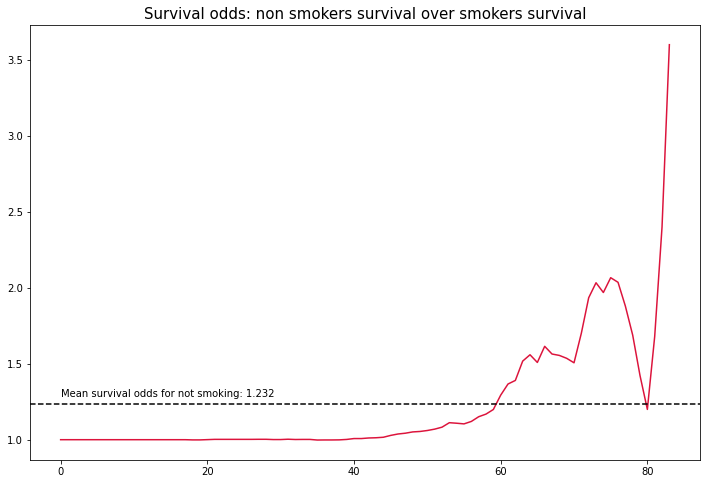

In [139]:
plt.figure(figsize=(12,8))
plt.plot(odds_survival, color='crimson')
plt.axhline(y=odds_survival.mean(),
            linestyle='--',
            color='black')
plt.text(x=0, 
         y=odds_survival.mean()+0.05,
         s=f"Mean survival odds for not smoking: {odds_survival.mean():.3f}")
plt.title("Survival odds: non smokers survival over smokers survival", size=15);

* Non smokers survival rates might get up to 2 times higher (excluding the peak of 3.5 times at 84 years) when compared to smokers survival rates.
* In average, non smokers are 1.23 times more likely to survive across all observed times than smokers.